# Statistics on GSMMs and HMDB compounds

Statistics and Global plots. 


In [28]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("/Users/lish/li.github/Li_CVK/lcvk")
from metModels import *
from polarPlot import *

In [3]:
# Get metabolic model
model = json.load(open('../data/metabolicModel_RECON3D_20210510.json'))
print(model['meta_data'])
model = json_convert_azmuth_mummichog(model)
print(model.keys(), len(model['Compounds']))

{'species': 'human', 'version': '', 'sources': ['https://github.com/VirtualMetabolicHuman, retrieved 2021-05-08'], 'status': '', 'last_update': '20210510', 'note': 'RECON3D cloned from https://github.com/VirtualMetabolicHuman, 2021-05-08.\nCompounds are decompartmentalized, but Reactions are not. \nThe redundant metabolites will be merged ad hoc when pathways and reactions are pulled.\n'}
dict_keys(['id', 'version', 'Compounds', 'dict_cpds_def', 'metabolic_rxns', 'cpd_edges', 'edge2rxn', 'rxn2edges', 'edge2enzyme', 'metabolic_pathways', 'cpd2pathways']) 4140


In [4]:
# humanGEM 
M = json.load(open('/Users/lish/li.proj/ipsc_atlas/metabolicModel_az_HumanGEM_20220302_noCompartmentalization.json'))
len(M['list_of_compounds'])

4112

In [35]:
hmdb = '/Users/lish/li.proj/Resources/HMDB-5/parsed_hmdb_metabolites.tsv'    

def get_formulaList_from_hmdb_parsed(hmdb):
    hmdb = open(hmdb).readlines()                                                                                    
    header = hmdb[0].split('\t')   
    print(len(hmdb)-1, header)
    formula_list_hmdb5 = []
    for line in hmdb[1:]:
        a = line.split('\t')
        if a[2].strip():
            formula_list_hmdb5.append(a[2].strip())
    
    return set(formula_list_hmdb5)

formula_list_hmdb5 = get_formulaList_from_hmdb_parsed(hmdb)
print(len(formula_list_hmdb5))

217920 ['accession', 'name', 'chemical_formula', 'monisotopic_molecular_weight', 'iupac_name', 'traditional_iupac', 'cas_registry_number', 'smiles', 'inchi', 'inchikey', 'kingdom', 'super_class', 'class', 'sub_class', 'logp', 'number_of_rings\n']
22566


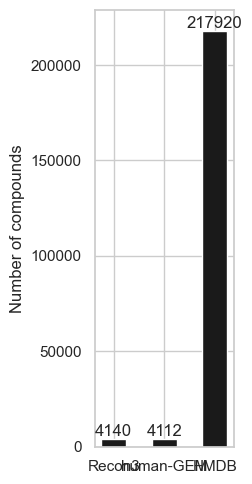

In [102]:
# Bar Fig. 2a
NNN = [4140, 4112, 217920]
fig, ax = plt.subplots(figsize=(2.6, 5))
p = ax.bar(['Recon3', 'human-GEM', 'HMDB'], NNN, 
        label=NNN,
        color='k', width=0.5)
ax.bar_label(p, label_type='edge')
ax.set_ylabel("Number of compounds")
plt.tight_layout()
plt.savefig('../output/bar_2a.pdf', dpi=300)

In [29]:
cpdDict = {}  # use charged_formula here for now; This is used for global map plot
bad = []
for C in model['Compounds'].values():
    if C['charged_formula'] and 'C' in C['charged_formula'] and 'X' not in C['charged_formula']:
        cpdDict[C['id']] = C
    else:
        bad.append((C['id']))
        
GEM_formulas = set([C['charged_formula'] for C in cpdDict.values()])
print(len(GEM_formulas))
print(cpdDict.get('hs_pre15', None))

model['cpds'] = model['Compounds']
Recon3_cpds = get_pathway_coordinates(model, cpdDict, formula='charged_formula')
print(len(Recon3_cpds))

2441
None
co2 CO2
Rtotal2 CO2FULLR2
Rtotal CO2FULLR
Rtotal3 CO2FULLR3
ca2 Ca
cl Cl
oxa C2O4
co CO
tcynt CNS
cynt CNO
CE4881 ClNO2
CE6000 CNO5
CE0074 C4N2O4
M03041 C2Cl3O2
cu2 Cu
3721


3618


(array([3.577e+03, 4.000e+00, 1.200e+01, 9.000e+00, 2.000e+00, 1.000e+00,
        4.000e+00, 4.000e+00, 0.000e+00, 5.000e+00]),
 array([ 0.42857143,  5.18571429,  9.94285714, 14.7       , 19.45714286,
        24.21428571, 28.97142857, 33.72857143, 38.48571429, 43.24285714,
        48.        ]),
 <BarContainer object of 10 artists>)

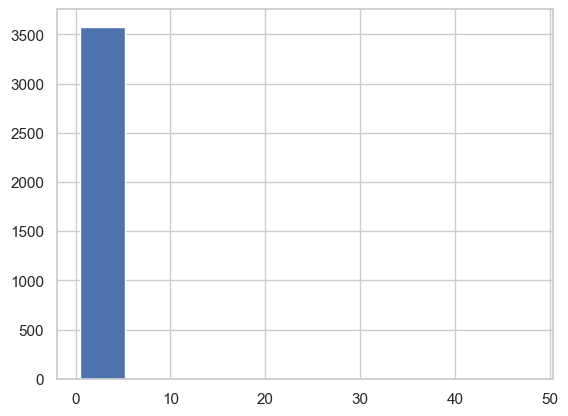

In [54]:
Recon3_cpds = [x for x in Recon3_cpds if 50 > x['ratio_H_C'] > 0]
print(len(Recon3_cpds))
plt.hist([x['ratio_H_C'] for x in Recon3_cpds])

In [37]:
hmdb_cpds = []
for f in formula_list_hmdb5:
    if 'C' in f and 'H' in f:
        hc, oc, nc, nops_c, ccs_offset = get_kvli_ratios(f, 0) # not using ccs_offset for now
        hmdb_cpds.append(
            {
                'formula': f,
                'ratio_H_C': hc,
                'ratio_O_C': oc,
                'ratio_N_C': nc,
                'ratio_NOPS': nops_c,
            }
        )
    else:
        pass
    
print(len(hmdb_cpds))

22182


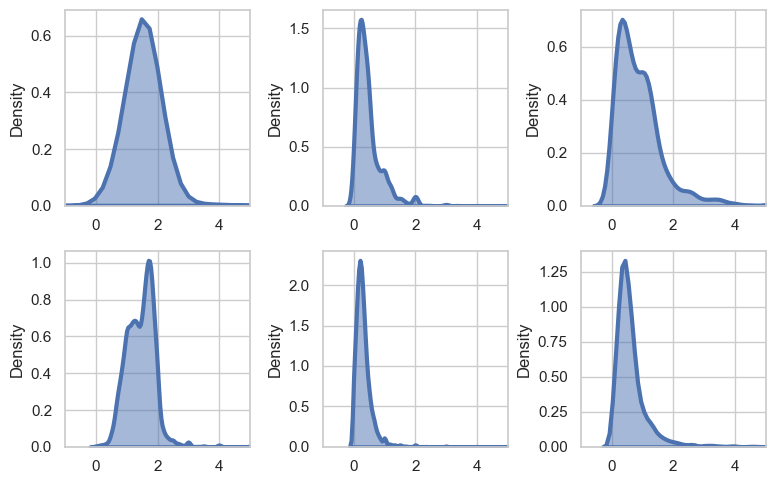

In [103]:
sns.set_theme(style="whitegrid")

ii = -1
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
for CPDS in [Recon3_cpds, hmdb_cpds]:
    ii += 1
    jj = -1
    for k in ['ratio_H_C', 'ratio_O_C', 'ratio_NOPS']:
        jj += 1
        sns.kdeplot( data=[x[k] for x in CPDS],  ax=axes[ii, jj], fill=True, alpha=.5, linewidth=3)
        axes[ii, jj].set_xlim(-1, 5)

plt.tight_layout()
plt.savefig('../output/kde_2b.pdf', dpi=300)

## Plot global maps

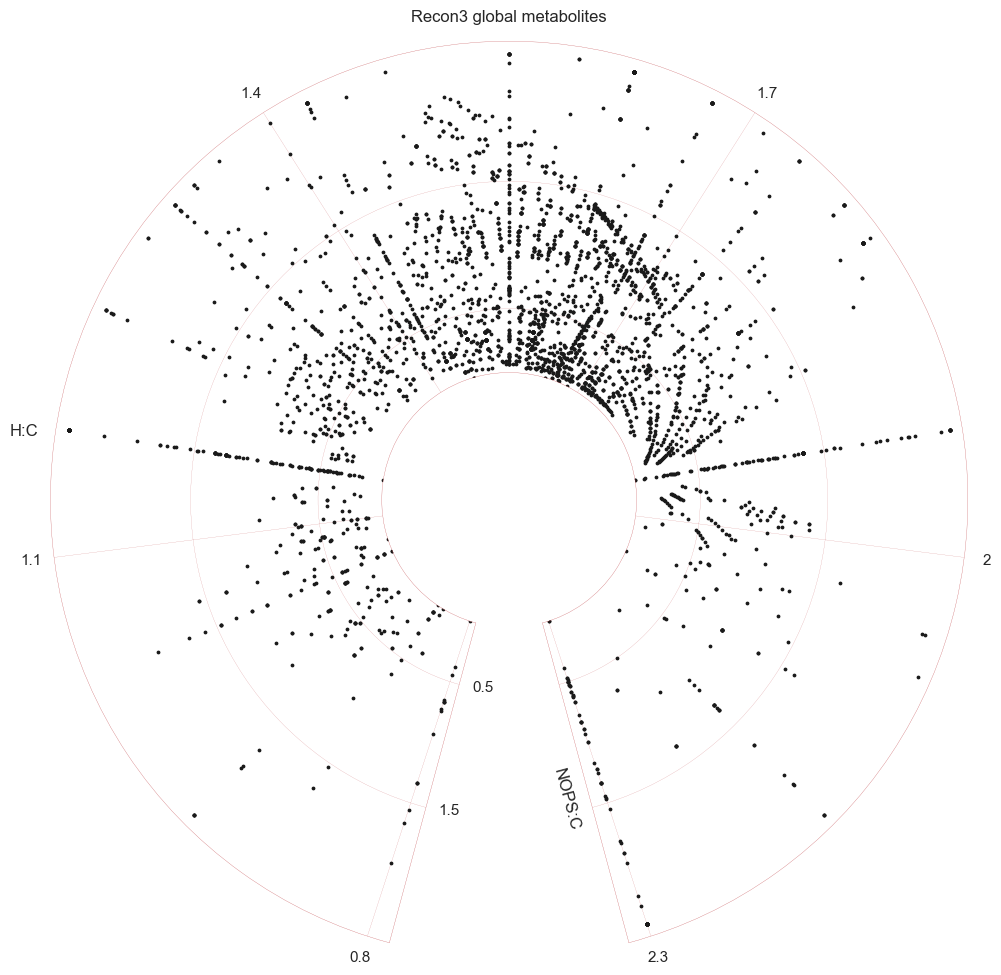

In [59]:

def plot_global_metabolites(allcpds, title='', outfile=''):
    '''Illustration only'''
    YMAX = 2.5
    min_radius=0
    max_radius=2.5
    theta_limit = (0.1*np.pi, 1.9*np.pi)
    theta_offset = 0.05         # so that nodes do not sit on border lines
    hcList = [max(min(x['ratio_H_C'], 2.5), 0.5) for x in allcpds]

    hcList = project_hc_data_radial(hcList)
    yList = [min(max(x['ratio_NOPS'], min_radius), max_radius) 
             for x in allcpds]

    # ticks reverse function of standardize_data
    xlabels = [ 0.8, 1.1, 1.4, 1.7, 2, 2.3]
    xticks = project_hc_data_radial(xlabels)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.subplots(subplot_kw={'projection': 'polar',  } 
    )
    c = ax.scatter(hcList, yList, marker='o', facecolors='k', 
                    # linewidths=.3, edgecolors='k', 
                    s=3,
    )
    ax.set_theta_zero_location('S')
    ax.set_theta_direction(-1)
    ax.set_thetalim((theta_limit[0]-theta_offset, theta_limit[1]+theta_offset))
    ax.set_ylim(0, YMAX + 0.1)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(x) for x in xlabels])

    ax.set_rgrids([0.5, 1.5])
    ax.grid(color='r', linewidth=0.1)
    for p in ax.spines.values():
        # inner, polar, start, end
        p.set_color('r')
        p.set_linewidth(0.2)

    ax.set_rorigin(-1)
    ax.text(1.7, YMAX + .45, "H:C", )
    ax.text(1.96*np.pi, 1.6, "NOPS:C", rotation=285)
    ax.set_title(title)
    plt.savefig(outfile, dpi=300)
    
    
plot_global_metabolites(Recon3_cpds, title='Recon3 global metabolites', 
                        outfile='../output/global_recon3.pdf')

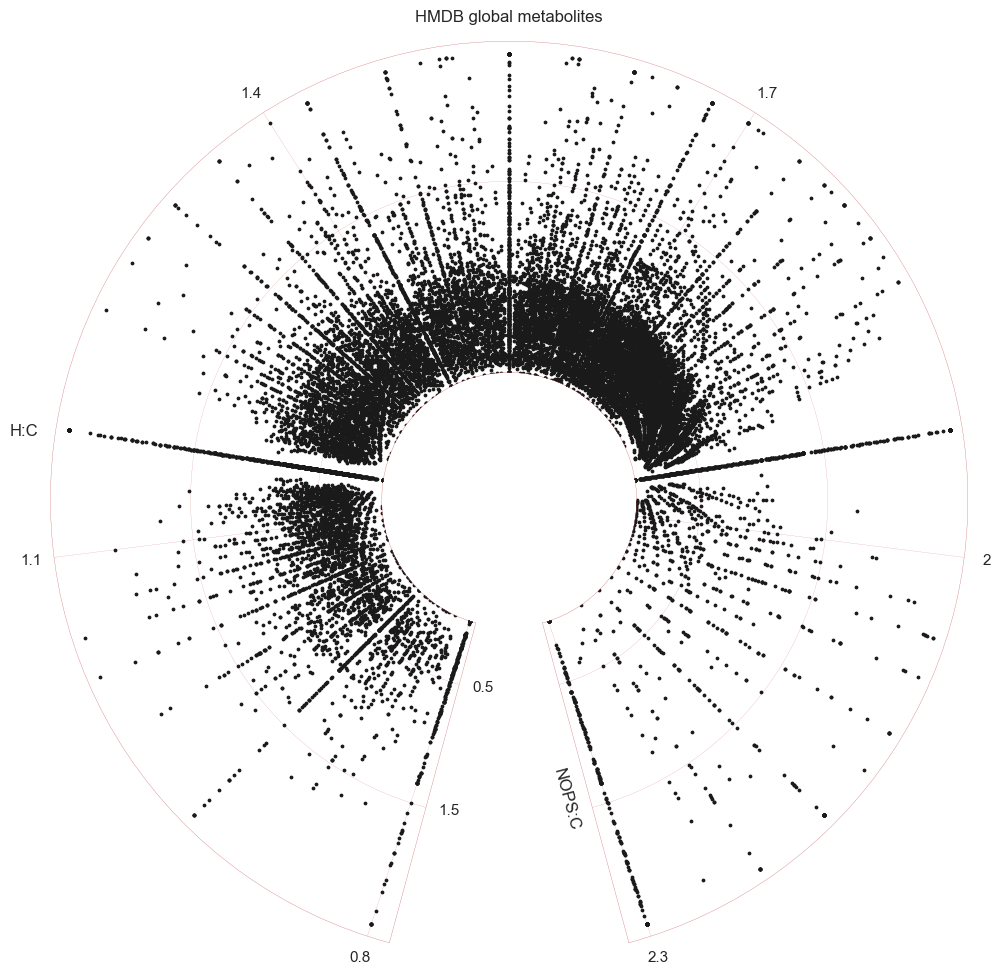

In [60]:
plot_global_metabolites(hmdb_cpds, title='HMDB global metabolites', 
                        outfile='../output/global_hmdb5.pdf')

In [91]:
pathwayslist = model['metabolic_pathways']
[pathwayslist[ii]['name'] for ii in [25, 83, 98]]

['Fatty acid oxidation', 'Steroid metabolism', 'Tyrosine metabolism']

In [92]:
green, magenta, black = [], [], []
for j in range(len(Recon3_cpds)):
    ii = Recon3_cpds[j]['id']
    if ii in pathwayslist[83]['cpds']:
        green.append(j)
    if ii in pathwayslist[25]['cpds']:
        magenta.append(j)
    if ii in pathwayslist[98]['cpds']:
        black.append(j)

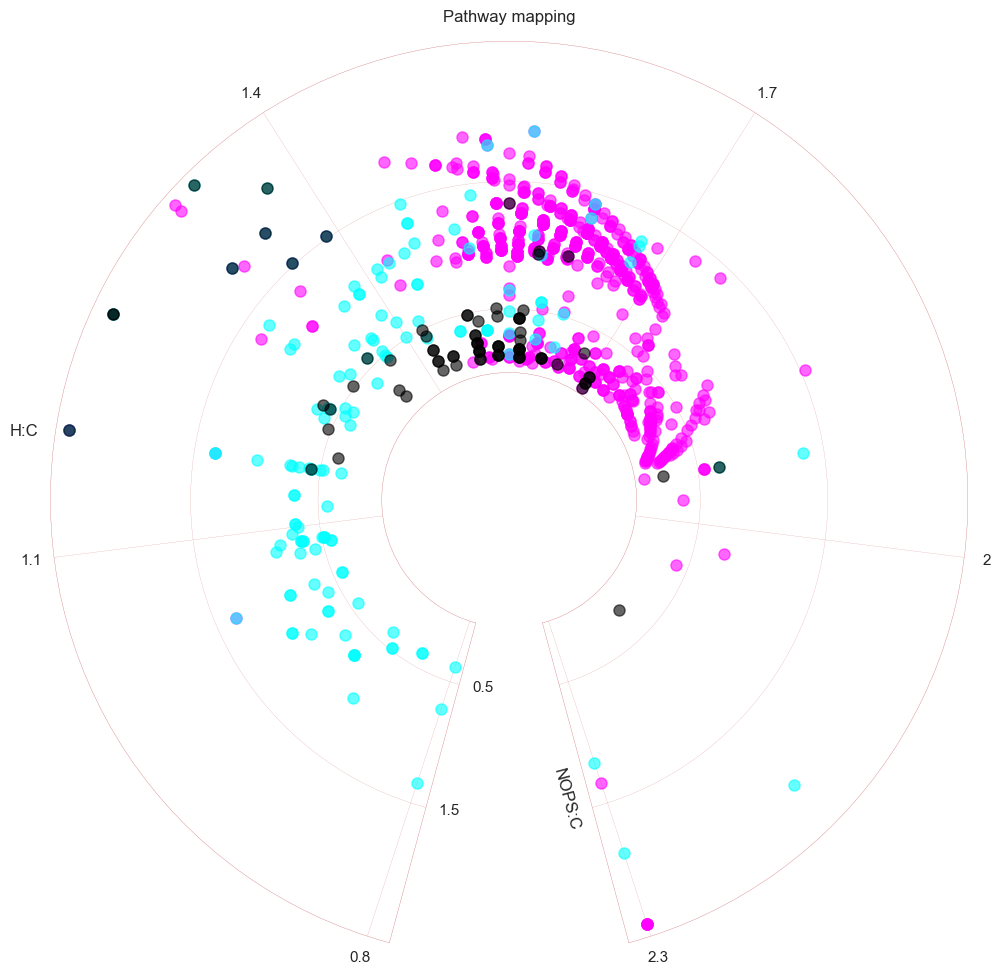

In [101]:
title='Pathway mapping' 
outfile='../output/example_3pathways_recon3_global.pdf'

YMAX = 2.5
min_radius=0
max_radius=2.5
theta_limit = (0.1*np.pi, 1.9*np.pi)
theta_offset = 0.05         # so that nodes do not sit on border lines
hcList = [max(min(x['ratio_H_C'], 2.5), 0.5) for x in Recon3_cpds]

hcList = project_hc_data_radial(hcList)
yList = [min(max(x['ratio_NOPS'], min_radius), max_radius) 
            for x in Recon3_cpds]

# ticks reverse function of standardize_data
xlabels = [ 0.8, 1.1, 1.4, 1.7, 2, 2.3]
xticks = project_hc_data_radial(xlabels)

fig = plt.figure(figsize=(12, 12))
ax = fig.subplots(subplot_kw={'projection': 'polar',  } 
)

collections = [ magenta, black, green]
colors_collections = ['magenta',  'cyan', 'black', ]
for ii in range(3):
    XX = [hcList[j] for j in collections[ii]]
    YY = [yList[j] for j in collections[ii]]
    ax.scatter(XX, YY, marker='o', facecolors=colors_collections[ii], 
               s=64, linewidths=1, edgecolors=colors_collections[ii],
               alpha=.6)

ax.set_theta_zero_location('S')
ax.set_theta_direction(-1)
ax.set_thetalim((theta_limit[0]-theta_offset, theta_limit[1]+theta_offset))
ax.set_ylim(0, YMAX + 0.1)
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xlabels])

ax.set_rgrids([0.5, 1.5])
ax.grid(color='r', linewidth=0.1)
for p in ax.spines.values():
    # inner, polar, start, end
    p.set_color('r')
    p.set_linewidth(0.2)

ax.set_rorigin(-1)
ax.text(1.7, YMAX + .45, "H:C", )
ax.text(1.96*np.pi, 1.6, "NOPS:C", rotation=285)
ax.set_title(title)
plt.savefig(outfile, dpi=300)

# Conclusion

This shows underlying reasons of developing lcvk. 

New visualization tools are needed for emerging large-scale biochemical data. 
New data from metabolomics and exposomics exceed the scale of GSMMs greatly.

Chemical properties are necessary to be part of navigation.